In [1]:
import numpy as np
import numpy.linalg as la
from itertools import combinations
from scipy.linalg import toeplitz
from collections import Counter
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt
import kblock_ising_model as kb

from scipy.integrate import solve_ivp

#Compare to other method

import sys
import os
from time import time
sys.path.append("../../../../src/")
#Imports
import single_particle_sector as sps
import numpy as np
import scipy as sp
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter


In [9]:
##Time Evolution Stuff

#First, We will define a Paramagnetic to Ferromagnetic quench
def h(t,tau,h0,hf):
    return h0-(h0-hf)*(t/tau)
# Define RHS
def rhs(t, X, k, J, h,h0,hf, tau):
    u, v = X
    hi = h(t, tau, h0,hf)
    du = -1j * (2 * J * (hi - np.cos(k)) * u + 2 * J * np.sin(k) * v)
    dv = -1j * (-2 * J * (hi - np.cos(k)) * v + 2 * J * np.sin(k) * u)
    return [du, dv]


In [50]:
#Basic Projector stuff
parity = False
J = 1
L = 100
k_vals = kb.k_vals(L)
g = np.linspace(0,5,100)
max_n = 6
#Ground states

U_gs = []
G_gs = []
for gi in g:
    U_gs.append(kb.U(k_vals,gi))
    H = sps.H_bdg(gi,L,J,"ABC")
    E,V = la.eigh(H)
    #The only sublety is this step
    #G_TFIM chooses ((1 0),(0 0 )) corr
    G = sps.G_tfim(V[:,L:])
    G_gs.append(G)

P_kblock = np.empty([max_n,len(g)])
P_BGS = np.empty([max_n,len(g)])

for i in range(len(g)):
    U = U_gs[i]
    G = G_gs[i]

    for n in range(1,max_n+1):
        P_kblock[n-1,i] = kb.P_n(n,U,k_vals,parity)
        P_BGS[n-1,i]= sps.P_n(n,G,L,parity)        



/home/kristian/Desktop/Subsystem Loschmidt Echo/subsystem_loschmidt_echo/scripts/mutual_info/exact_diag/Integrable Ising Model/kblock_ising_model.py:130: ComplexWarning: Casting complex values to real discards the imaginary part
  C[nx,ny] = D(Nd,T,k)


Text(0.5, 1.0, 'Solid = Kblock')

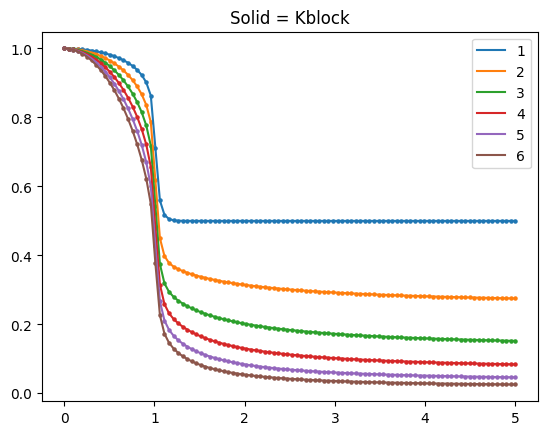

In [51]:
plot(g,P_kblock.T, label = [1,2,3,4,5,6])
for i in range(max_n):
    plt.scatter(g,P_BGS[i,:],s=5)
plt.legend()
plt.title("Solid = Kblock")

# TIME EVOLUTION

In [45]:
#Model params
L = 100
h0 = 0
hf = 5
tau = 50
J = 1.0
N_steps = 50
#Define momentum
k = (2 * np.arange(-L//2, L//2) + 1) * np.pi / (L )
u0, v0 = kb.U(k,h0)
t_span = (0, tau)
t_eval = np.linspace(*t_span, N_steps)
h_plotting = h(t_eval,tau,h0,hf)
#BGS Time Evolution 
U_bdgt_t   = sps.TFIM_time_evolve(N_steps,tau, h0,hf, J, L, U0= None, bc = "ABC")

#Kblock Method
U_kblock_t = np.zeros((2, L, len(t_eval)), dtype=complex)
for i, k_i in enumerate(k):
    y0 = np.array([u0[i], v0[i]], dtype=complex)
    sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, args=(k_i, J, h, h0,hf, tau), method='RK45',max_step=0.05)
    U_kblock_t[0, i, :] = sol.y[0]  # u_k(t)
    U_kblock_t[1, i, :] = sol.y[1]  # v_k(t)



/home/kristian/miniconda3/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `dtype`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


In [48]:
parity = False
max_n = 6
##Calculating Projectors
P_kblock_t = np.empty([max_n,len(t_eval)])
P_BGS_t = np.empty([max_n,len(t_eval)])

for i in range(N_steps):
    #Transform both to be calculable 
    U = U_kblock_t[:,:,i]
    G = sps.G_tfim(U_bdgt_t[i][:,L:])
    #Compute Projectors
    for n in range(1,max_n+1):
        P_kblock_t[n-1,i] = kb.P_n(n,U,k_vals,parity)
        P_BGS_t[n-1,i]= sps.P_n(n,G,L,parity)        

/home/kristian/Desktop/Subsystem Loschmidt Echo/subsystem_loschmidt_echo/scripts/mutual_info/exact_diag/Integrable Ising Model/kblock_ising_model.py:130: ComplexWarning: Casting complex values to real discards the imaginary part
  C[nx,ny] = D(Nd,T,k)
/home/kristian/Desktop/Subsystem Loschmidt Echo/subsystem_loschmidt_echo/scripts/mutual_info/exact_diag/Integrable Ising Model/../../../../src/single_particle_sector.py:174: ComplexWarning: Casting complex values to real discards the imaginary part
  C[nx,ny] = M[Bx,Ay]


/tmp/ipykernel_23373/588589398.py:4: MatplotlibDeprecationWarning: Passing label as a length 6 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(g,P_kblock[i,:], label = [1,2,3,4,5,6])
/tmp/ipykernel_23373/588589398.py:9: MatplotlibDeprecationWarning: Passing label as a length 6 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(g,P_kblock[i,:], label = [1,2,3,4,5,6])


(0.0, 5.0)

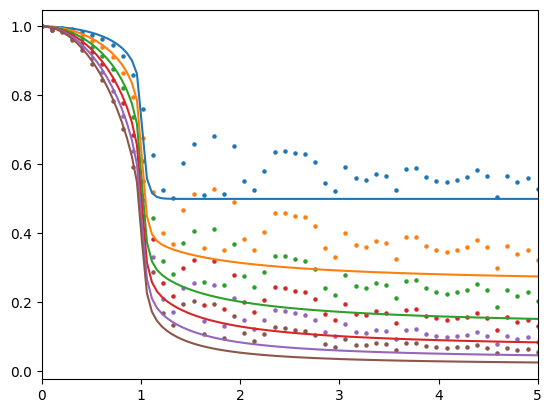

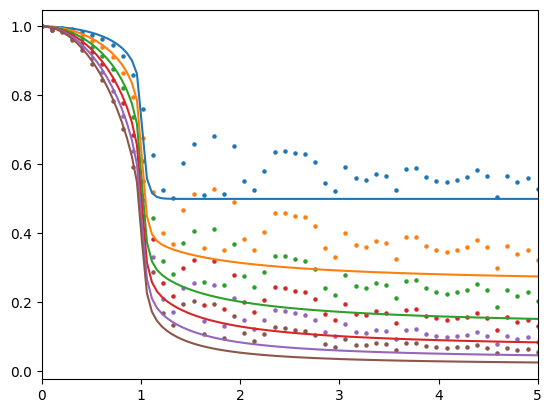

In [54]:
plt.figure()
for i in range(len(P_kblock_t)):
    plt.scatter(h_plotting, P_kblock_t[i], label=f"{i}",s=5)
    plt.plot(g,P_kblock[i,:], label = [1,2,3,4,5,6])
plt.xlim(0,5)
plt.figure()
for i in range(len(P_kblock_t)):
    plt.scatter(h_plotting, P_kblock_t[i], label=f"{i}",s=5)
    plt.plot(g,P_kblock[i,:], label = [1,2,3,4,5,6])
plt.xlim(0,5)

# They are evidentally the exact same and this was a waste of time. Only thing to check left is tau for stability

In [57]:
#Model params
L = 100
h0 = 0
hf = 5
J = 1.0
k = (2 * np.arange(-L//2, L//2) + 1) * np.pi / (L )
N_steps = 50

###
taus = np.array([.1,1,5,10,15,20,25,100])

##
k_block_taus =[]
Bgs_block_taus =[]
times_tau = []
for tau in taus:
    #Define momentum
    u0, v0 = kb.U(k,h0)
    t_span = (0, tau)
    t_eval = np.linspace(*t_span, N_steps)
    h_plotting = h(t_eval,tau,h0,hf)
    #BGS Time Evolution 
    U_bdgt_t   = sps.TFIM_time_evolve(N_steps,tau, h0,hf, J, L, U0= None, bc = "ABC")
    #Kblock Method
    U_kblock_t = np.zeros((2, L, len(t_eval)), dtype=complex)
    for i, k_i in enumerate(k):
        y0 = np.array([u0[i], v0[i]], dtype=complex)
        sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, args=(k_i, J, h, h0,hf, tau), method='RK45',max_step=0.05)
        U_kblock_t[0, i, :] = sol.y[0]  # u_k(t)
        U_kblock_t[1, i, :] = sol.y[1]  # v_k(t)
    k_block_taus.append(U_kblock_t)
    Bgs_block_taus.append(U_bdgt_t)
    times_tau.append(t_eval)

/home/kristian/miniconda3/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `dtype`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


In [58]:
P_kblock_taus = []
P_BGS_taus = []
for tau in range(len(taus)):

    U_kblock_t = k_block_taus[tau]
    U_bdgt_t = Bgs_block_taus[tau]
    parity = False
    max_n = 6
    ##Calculating Projectors
    P_kblock_t = np.empty([max_n,len(t_eval)])
    P_BGS_t = np.empty([max_n,len(t_eval)])

    for i in range(N_steps):
        #Transform both to be calculable 
        U = U_kblock_t[:,:,i]
        G = sps.G_tfim(U_bdgt_t[i][:,L:])
        #Compute Projectors
        for n in range(1,max_n+1):
            P_kblock_t[n-1,i] = kb.P_n(n,U,k_vals,parity)
            P_BGS_t[n-1,i]= sps.P_n(n,G,L,parity)  

    P_kblock_taus.append(P_kblock_t)
    P_BGS_taus.append(P_BGS_t)


/home/kristian/Desktop/Subsystem Loschmidt Echo/subsystem_loschmidt_echo/scripts/mutual_info/exact_diag/Integrable Ising Model/kblock_ising_model.py:130: ComplexWarning: Casting complex values to real discards the imaginary part
  C[nx,ny] = D(Nd,T,k)
/home/kristian/Desktop/Subsystem Loschmidt Echo/subsystem_loschmidt_echo/scripts/mutual_info/exact_diag/Integrable Ising Model/../../../../src/single_particle_sector.py:174: ComplexWarning: Casting complex values to real discards the imaginary part
  C[nx,ny] = M[Bx,Ay]


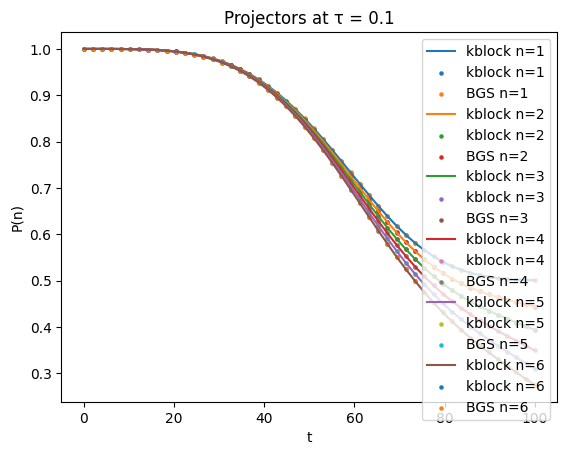

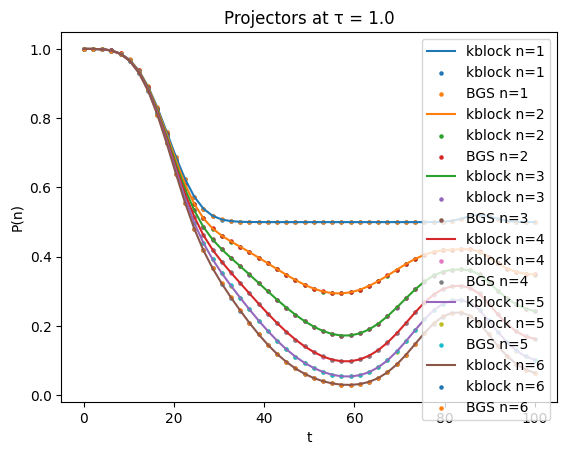

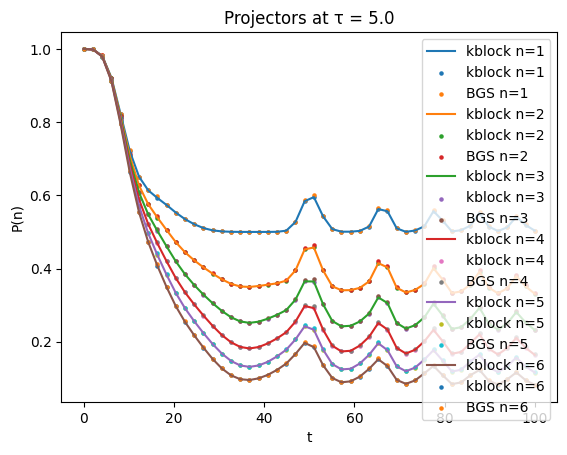

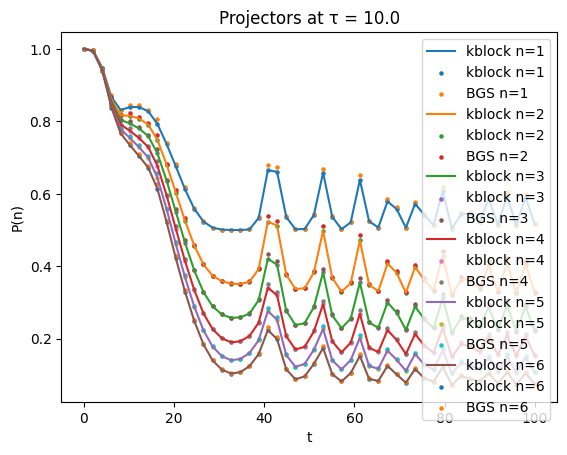

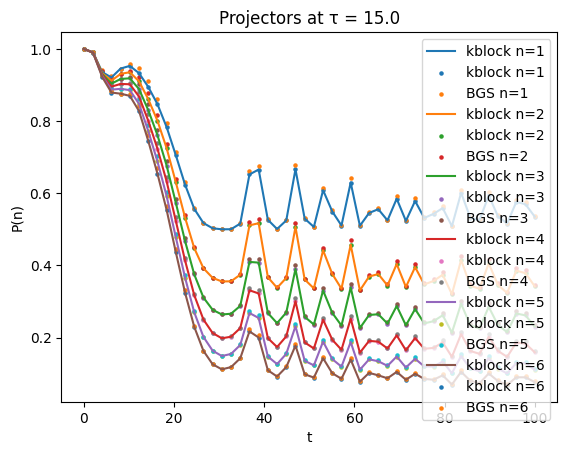

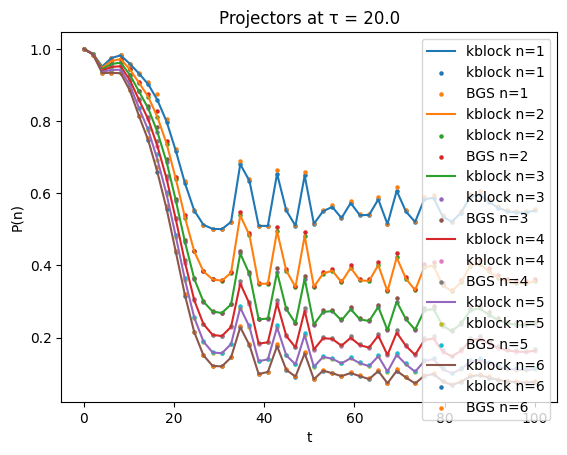

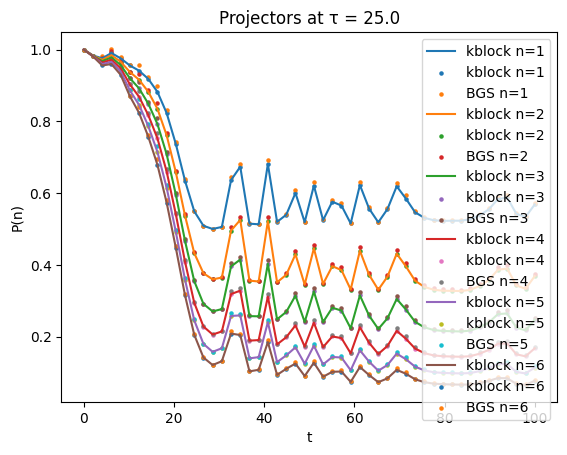

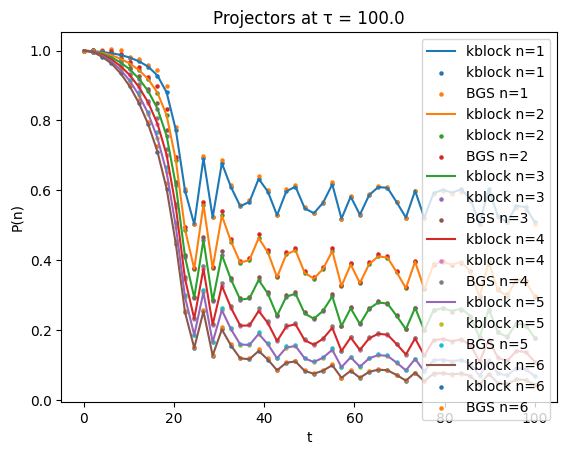

In [60]:
for tau_idx in range(len(taus)):
    plt.figure()
    for n in range(P_kblock_taus[tau_idx].shape[0]):
        plt.plot(t_eval, P_kblock_taus[tau_idx][n], label=f"kblock n={n+1}")
        plt.scatter(t_eval, P_kblock_taus[tau_idx][n],s=5, label=f"kblock n={n+1}")

        plt.scatter(t_eval, P_BGS_taus[tau_idx][n], s=5, label=f"BGS n={n+1}")
    plt.title(f"Projectors at τ = {taus[tau_idx]}")
    plt.xlabel("t")
    plt.ylabel("P(n)")
    plt.legend()
